
# Sales Analysis & Forecasting (Python, Jupyter Lab)
Author: ARNAB BAG


This notebook:
- Generates or loads sales data
- Explores and visualizes patterns
- Aggregates to monthly totals
- Fits a SARIMAX model
- Evaluates on a holdout
- Forecasts the next 6 months

**Files created by the workflow:**
- `sales_data.csv` — synthetic dataset saved in the same folder


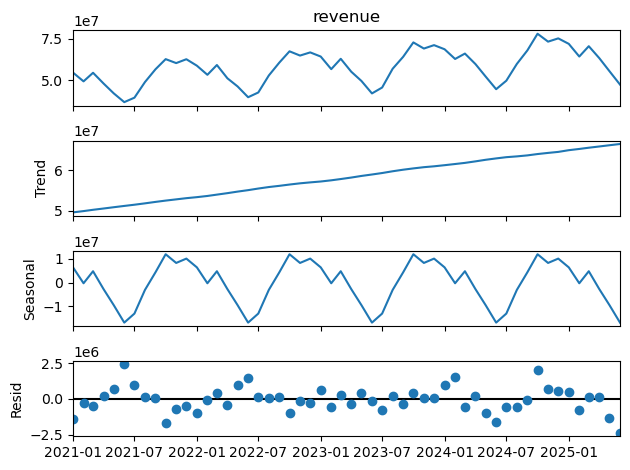

C:\Users\arnab\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Holdout MAE: 1123435.11
Holdout MAPE (%): 1.73


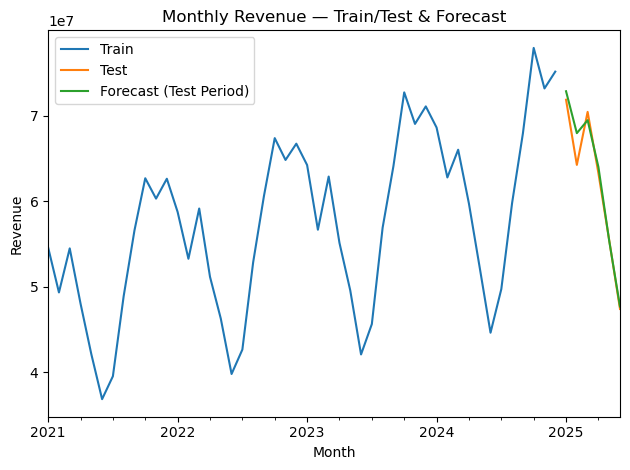

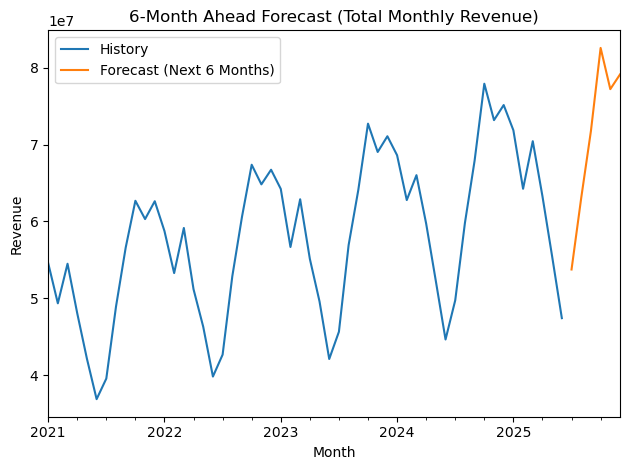

In [4]:

# You can paste the code from the original run here if needed.
# To keep this notebook compact, we'll re-run the essential pieces:
import numpy as np, pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

# Load the CSV generated earlier (or replace with your own)
df = pd.read_csv("sales_data.csv", parse_dates=["date"])

daily_sales = df.groupby("date", as_index=True)["revenue"].sum().sort_index()
monthly_sales = daily_sales.resample("MS").sum()

# Decompose
decomp = seasonal_decompose(monthly_sales, model="additive", period=12, extrapolate_trend="freq")
_ = decomp.plot()
plt.tight_layout()
plt.show()

cutoff = pd.Timestamp("2024-12-01")
train = monthly_sales[monthly_sales.index <= cutoff]
test  = monthly_sales[(monthly_sales.index > cutoff) & (monthly_sales.index <= pd.Timestamp("2025-06-01"))]

model = SARIMAX(train, order=(1,1,1), seasonal_order=(1,1,1,12), enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)

forecast_test = res.get_forecast(steps=len(test)).predicted_mean
future_steps = 6
future_forecast = res.get_forecast(steps=len(test) + future_steps).predicted_mean
future_forecast = future_forecast.iloc[len(test):]

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-9, None))) * 100

mae = mean_absolute_error(test, forecast_test)
mape_val = mape(test, forecast_test)

print("Holdout MAE:", round(mae,2))
print("Holdout MAPE (%):", round(mape_val,2))

plt.figure()
plt.title("Monthly Revenue — Train/Test & Forecast")
train.plot(label="Train")
test.plot(label="Test")
forecast_test.plot(label="Forecast (Test Period)")
plt.legend()
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()

plt.figure()
plt.title("6‑Month Ahead Forecast (Total Monthly Revenue)")
monthly_sales.plot(label="History")
future_forecast.plot(label="Forecast (Next 6 Months)")
plt.legend()
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.tight_layout()
plt.show()
